### Dataset can be used

- In this example, we use fruit-360-small

#### Fruit - 360 data

- Data from https://www.kaggle.com/moltean/fruits


#### Blood Cell Data
- Data from https://www.kaggle.com/paultimothymooney/blood-cells#dataset2-master.zip
- use dataset2-master.zip

In [1]:
# https://deeplearningcourses.com/c/advanced-computer-vision
# https://www.udemy.com/advanced-computer-vision

from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

from keras.layers import Input,Lambda, Dense,Flatten
from keras.models import Model
from keras.applications.resnet50 import ResNet50,preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from glob import glob


Using TensorFlow backend.


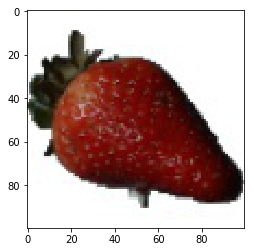

In [2]:
IMAGE_SIZE = [224, 224]
epochs  =16
batch_size = 32


# https://www.kaggle.com/moltean/fruits
# train_path = '../large_files/fruits-360/Training'
# valid_path = '../large_files/fruits-360/Validation'
train_path = 'data/fruits-360-small/Training'
valid_path = 'data/fruits-360-small/Validation'


# useful for getting number of files
image_files = glob(train_path+'/*/*.jp*g')
valid_image_files = glob(valid_path+'/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path+'/*')
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [3]:
res = ResNet50(input_shape = IMAGE_SIZE+[3],weights = 'imagenet',include_top = False)

for layer in res.layers:
    layer.trainable =False
    
x = Flatten()(res.output)
prediction = Dense(len(folders),activation = 'softmax')(x)

model = Model(inputs = res.input,outputs = prediction)

model.summary()


Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
____________________________________

#### Data Augmentation

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Found 1289 images belonging to 8 classes.
{'Banana': 2, 'Apple Golden 1': 0, 'Avocado': 1, 'Kiwi': 3, 'Mango': 5, 'Strawberry': 7, 'Lemon': 4, 'Raspberry': 6}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -122.68 max: 151.061


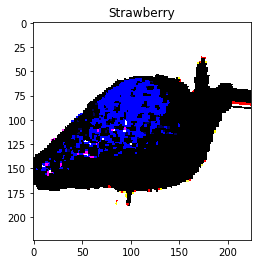

In [4]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = 'rmsprop',
             metrics = ['accuracy'])

gen = ImageDataGenerator(rotation_range =20,
                        width_shift_range = 0.1,
                        height_shift_range = 0.1,
                        shear_range = 0.1,
                        zoom_range = 0.2,
                        horizontal_flip = True,
                        vertical_flip = True,
                        preprocessing_function = preprocess_input)

# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path,target_size = IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k,v in test_gen.class_indices.items():
    labels[v] = k
    
for x,y in test_gen:
    print('min:',x[0].min(),'max:',x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

#### Fit Model

-  create generators

In [5]:
train_generator = gen.flow_from_directory(
train_path,target_size =IMAGE_SIZE,
shuffle = True, batch_size = batch_size)

valid_generator = gen.flow_from_directory(
valid_path,target_size = IMAGE_SIZE,
shuffle = True,batch_size = batch_size)



r=model.fit_generator(train_generator,
                     validation_data = valid_generator,
                     epochs = epochs,
                     steps_per_epoch = len(image_files)//batch_size,
                     validation_steps = len(valid_image_files)//batch_size)


Found 3839 images belonging to 8 classes.
Found 1289 images belonging to 8 classes.
Epoch 1/16
120/119 [==============================] - 173s 1s/step - loss: 0.1554 - acc: 0.9700 - val_loss: 0.0295 - val_acc: 0.9930
Epoch 2/16
120/119 [==============================] - 177s 1s/step - loss: 0.0080 - acc: 0.9987 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3/16
120/119 [==============================] - 182s 2s/step - loss: 0.0014 - acc: 1.0000 - val_loss: 1.9027e-04 - val_acc: 1.0000
Epoch 4/16
120/119 [==============================] - 181s 2s/step - loss: 5.0961e-04 - acc: 1.0000 - val_loss: 3.9074e-04 - val_acc: 1.0000
Epoch 5/16
120/119 [==============================] - 184s 2s/step - loss: 0.0017 - acc: 0.9992 - val_loss: 5.3441e-04 - val_acc: 1.0000
Epoch 6/16
120/119 [==============================] - 186s 2s/step - loss: 0.0033 - acc: 0.9990 - val_loss: 7.5041e-05 - val_acc: 1.0000
Epoch 7/16
120/119 [==============================] - 185s 2s/step - loss: 9.5856e-04 - acc: 0.999

#### Confusion Matrix

In [8]:
def get_confusion_matrix(data_path,N):
  # we need to see the data in the same order
  # for both predictions and targets
    print("Generating confusion matrix",N)
    predictions = []
    targets = []
    i = 0
    for x, y in gen.flow_from_directory(data_path, target_size = IMAGE_SIZE,shuffle = False,batch_size = batch_size*2):
        i +=1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p,axis = 1)
        y = np.argmax(y,axis = 1)
        predictions = np.concatenate((predictions,p))
        targets = np.concatenate((targets,y))
        
        if len(targets) >=N:
            break

    cm = confusion_matrix(targets,predictions)
    return cm

cm = get_confusion_matrix(train_path,len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path,len(valid_image_files))
print(valid_cm)

    

Generating confusion matrix 3839
Found 3839 images belonging to 8 classes.
50
[[492   0   0   0   0   0   0   0]
 [  0 427   0   0   0   0   0   0]
 [  0   0 490   0   0   0   0   0]
 [  0   0   0 466   0   0   0   0]
 [  0   0   0   0 492   0   0   0]
 [  0   0   0   0   0 490   0   0]
 [  0   0   0   0   0   0 490   0]
 [  0   0   0   0   0   0   0 492]]
Generating confusion matrix 1289
Found 1289 images belonging to 8 classes.
[[164   0   0   0   0   0   0   0]
 [  0 143   0   0   0   0   0   0]
 [  0   0 166   0   0   0   0   0]
 [  0   0   0 156   0   0   0   0]
 [  0   0   0   0 164   0   0   0]
 [  0   0   0   0   0 166   0   0]
 [  0   0   0   0   0   0 166   0]
 [  0   0   0   0   0   0   0 164]]


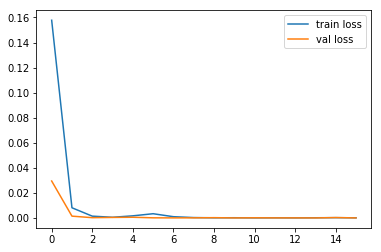

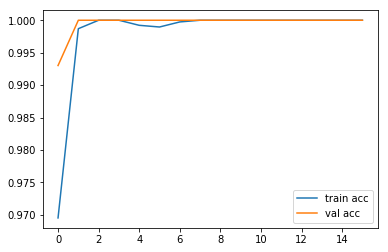

Confusion matrix, without normalization
[[492   0   0   0   0   0   0   0]
 [  0 427   0   0   0   0   0   0]
 [  0   0 490   0   0   0   0   0]
 [  0   0   0 466   0   0   0   0]
 [  0   0   0   0 492   0   0   0]
 [  0   0   0   0   0 490   0   0]
 [  0   0   0   0   0   0 490   0]
 [  0   0   0   0   0   0   0 492]]


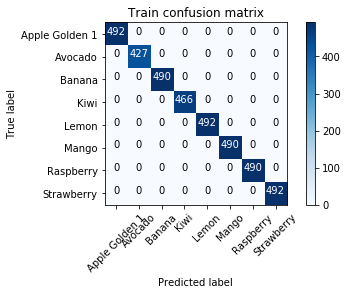

Confusion matrix, without normalization
[[164   0   0   0   0   0   0   0]
 [  0 143   0   0   0   0   0   0]
 [  0   0 166   0   0   0   0   0]
 [  0   0   0 156   0   0   0   0]
 [  0   0   0   0 164   0   0   0]
 [  0   0   0   0   0 166   0   0]
 [  0   0   0   0   0   0 166   0]
 [  0   0   0   0   0   0   0 164]]


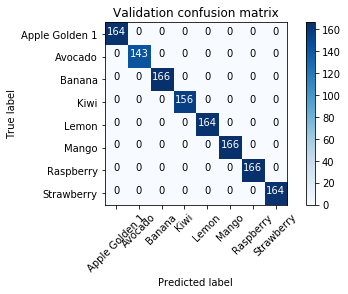

In [9]:
# plot some data

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

from util import plot_confusion_matrix
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')